#### 0. Imports & definitions

In [1]:
import cfinversion
from cfinversion.tools import lre
from cfinversion.distributions import *
import numpy as np
import pandas as pd

In [2]:
#setting svg-backend
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
#font shenanigans
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = 'False'
# colorblind-safe cmap
from tol_colors import tol_cmap, tol_cset

In [3]:
from cfinversion.continuous import *
def fit_methods(cf, N = 10000, delta=10e-3, trunc = None):
  trunc = trunc or N * delta
  methods = {
            'Bohman A' : BohmanA(N=N,delta=delta),
            'Bohman B' : BohmanB(N=N,delta=delta),
            'Bohman C' : BohmanC(N=N,delta=delta),
            'Bohman D' : BohmanD(N=N,delta=delta, K = 4), 
            'Bohman E' : BohmanE(N=N,delta=delta, K = 8),
            'Naive Integral' : NaiveGPInverter(N = int(N*delta), delta = delta, num_points = 2*N - 1),
            'DFT approxim.'  : FFTInverter(N=N, A = -trunc, B = trunc)
            }
  for method in methods:
    methods[method].fit(cf)
  return methods

def run_tests(cases):
  results = {}
  for case in cases: 
    print(f'case {case['name']}:', end = ' ')
    results[case['name']] = {}
    for i, targs in enumerate(case["test_arg"]):
      print('#', end='')
      results[case['name']][i] = fit_methods(case['dist'].chr, **targs)
    print(';')
  return results

def compute_metrics(cases, results):
  metrics = {}
  for case in cases: 
    print(f'Metrics {case['name']}:', end = ' ')
    metrics[case['name']] = {}
    for i, targs in enumerate(case["test_arg"]):
      print('#', end='')
      metrics[case['name']][i] = {}
      for m, estim in results[case['name']][i].items():
        metrics[case['name']][i][m] = compute_case_metrics(case['dist'], estim, case['test_pts'], tol_diff=1e-5 if m[:-2] == "Bohman" else None)      
    print(';')
  return metrics 
  
def compute_case_metrics(dist, estimated, x, tol_diff=None):
  errors_cdf = dist.cdf(x) - estimated.cdf(x)
  if tol_diff is not None:
    errors_pdf = dist.pdf(x) - estimated.pdf(x, tol_diff=tol_diff)
  else:
    errors_pdf = dist.pdf(x) - estimated.pdf(x)
  metrics = {}
  metrics['sup_error_pdf'] = np.max(np.abs(errors_pdf))
  metrics['sup_error_cdf'] = np.max(np.abs(errors_cdf))
  metrics['mae_pdf'] = np.mean(np.abs(errors_pdf))
  metrics['mae_cdf'] = np.mean(np.abs(errors_cdf))
  metrics['mse_pdf'] = np.mean(np.abs(errors_pdf**2))
  metrics['mse_cdf'] = np.mean(np.abs(errors_cdf**2))
  metrics['mae_std_pdf'] = np.std(np.abs(errors_pdf))
  metrics['mae_std_cdf'] = np.std(np.abs(errors_cdf))
  metrics['mse_std_pdf'] = np.std(errors_pdf**2)
  metrics['mse_std_cdf'] = np.std(errors_cdf**2)
  return metrics
  

# Case Study:

In [4]:
epsilon = 0.01
x_sym = np.linspace(-2, 2, 500)
x_pos = np.linspace(0 + epsilon, 1 - epsilon, 500)
N     = [1000, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000]
delta = [1e-2] * len(N)
trunc = [np.pi / (2 * delta[0])] * len(N)
cases = [{
    "name"      : "Normal",
    "dist"      : Norm(0, 1),
    "test_pts"  : x_sym,
    "test_arg"  : [{"N": n, "delta" : d, "trunc" : t} for n, d, t in zip(N, delta, trunc)]
  },{
    "name"      : "Laplace",
    "dist"      : Laplace(0, 1),
    "test_pts"  : x_sym,
    "test_arg"  : [{"N": n, "delta" : d, "trunc" : t} for n, d, t in zip(N, delta, trunc)]
  },{
    "name"      : "Uniform",
    "dist"      : Uniform(0, 1),
    "test_pts"  : x_pos,
    "test_arg"  : [{"N": n, "delta" : d, "trunc" : t} for n, d, t in zip(N, delta, trunc)]
  },{
    "name"      : "UniformSquared",
    "dist"      : UniformSquared(0, 1),
    "test_pts"  : x_pos,
    "test_arg"  : [{"N": n, "delta" : d, "trunc" : t} for n, d, t in zip(N, delta, trunc)]
  }
]
results = run_tests(cases)
metrics = compute_metrics(cases, results)
methods = list(results['Normal'][0].keys())

case Normal: #########;
case Laplace: #########;
case Uniform: #########;
case UniformSquared: #########;
Metrics Normal: #########;
Metrics Laplace: #########;
Metrics Uniform: #########;
Metrics UniformSquared: #########;


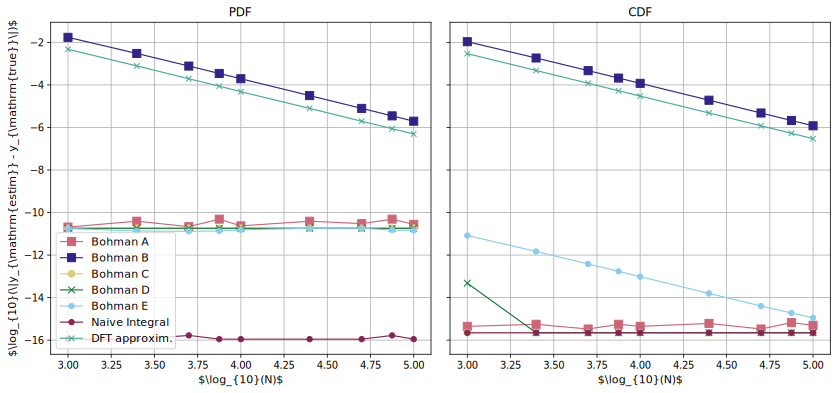

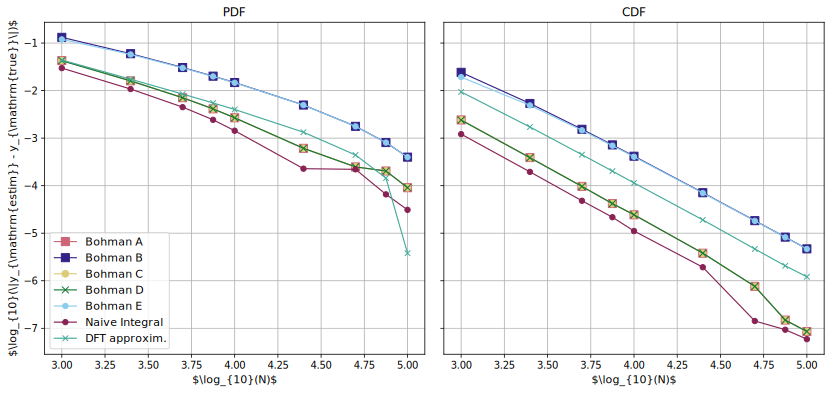

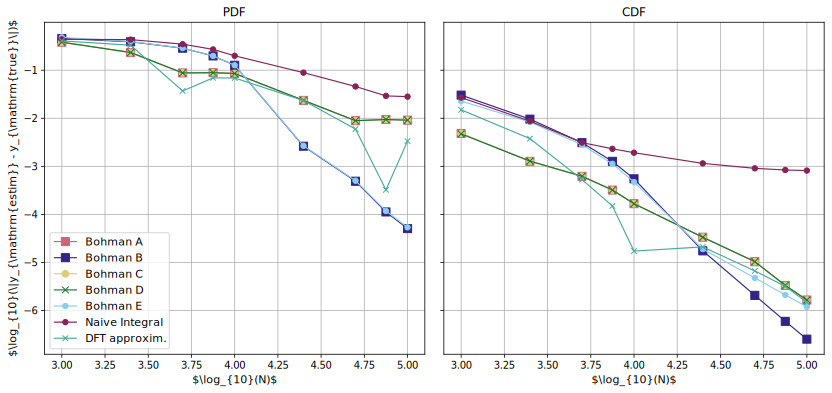

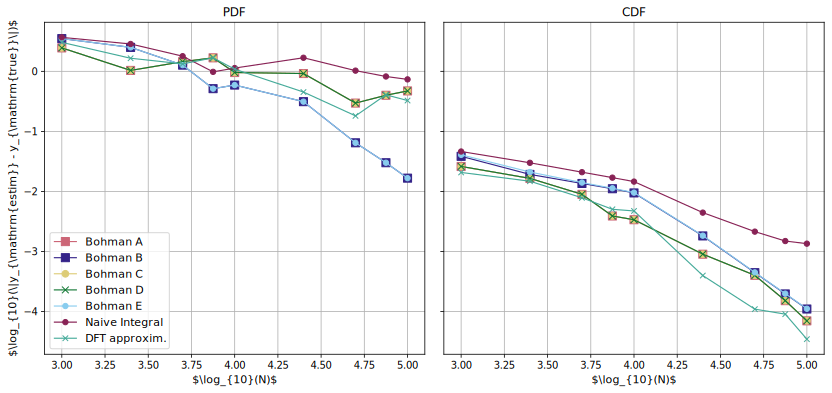

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(ax, case, metrics, ft='pdf'): 
  markers = ['s','s','o','x','o','o','x']
  markers_size = [6,6,5,5,4,4,4.1]
  cmap = tol_cset('muted') #['#577590', '#90be6d', '#f9c74f', '#f94144', '#3d0066', '#c86bfa',  '#219ebc']
  for i, method in enumerate(methods):
    score = f"sup_error_{ft}"
    test_num = len(case['test_arg'])
    err = np.array([metrics[case['name']][t][method][f'{score}'] for t in range(test_num)])
    ax.plot([np.log10(case['test_arg'][t]['N']) for t in range(test_num)], np.log10(err),
            marker=markers[i], linewidth=1.15, color=cmap[i], markersize=1.35*markers_size[i], label = f'{method}')

for i in range(4):
  fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
  plot_results(axs[0], cases[i], metrics, ft='pdf')
  #axs[0].set_title(f'Супремум модулей ошибок для CDF')
  axs[0].set_title(f'PDF')
  plot_results(axs[1], cases[i], metrics, ft='cdf')
  #axs[1].set_title(f'Супремум модулей ошибок для PDF')
  axs[1].set_title(f'CDF')
  axs[0].legend(prop={'size':11}, loc='lower left')
  axs[0].set_ylabel(r'\$\log_{10}(\|y_{\mathrm{estim}} - y_{\mathrm{true}}\|)\$', size=11)
  for ax in axs:
    ax.grid()
    #ax.legend()
    #ax.set_ylabel(r'\$\log_{10}(\varepsilon)\$')
    ax.set_xlabel(r'\$\log_{10}(N)\$', size=11)
  #axs[1].yaxis.set_tick_params(labelbottom=True)
  fig.subplots_adjust(wspace=0.05)
  fig.savefig(f'plots/{cases[i]['name']}_error_convergence.svg')